# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
from config import api_key
from random import uniform
from citipy import citipy
from pprint import pprint
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import os


## Generate Cities List

In [35]:
weather_df_10 = pd.DataFrame()

In [2]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={api_key}&units={units}&q="
print(query_url)

http://api.openweathermap.org/data/2.5/weather?appid=0b033578e7c13db14078c6b6940e0b4d&units=imperial&q=


In [3]:
# generate 5000 random lat long coordinates
def newpoint():
   return uniform(-180,180), uniform(-90, 90)

points = [newpoint() for x in range(5000)]

# set up lists to hold reponse info
cities = []
hum = []
temp = []
cld = []
wind_spd = []
hemisphere = []
lats = []
longs = []

# Loop through the list of points, find closest city and perform a request for data on each
for point in points:
    lat = point[0]
    long = point[1]
    city = citipy.nearest_city(point[0], point[1])
    cities.append(city.city_name)
    lats.append(lat)
    longs.append(long)
    if lat >= 0:
            hemisphere.append('northern')
    else:
        hemisphere.append('southern')
    
weatherPy_dict = {
    "city": cities,    
    "lat": lats, 
    "long": longs, 
    "hemisphere": hemisphere
}

weather_df = pd.DataFrame(weatherPy_dict)
weather_df.head()


,city,lat,long,hemisphere
0,pangnirtung,68.135893,-63.882825,northern
1,hithadhoo,-1.504840,71.619806,southern
2,qaanaaq,146.548647,-57.718503,northern
3,ushuaia,-138.062346,-20.383675,southern
4,qaanaaq,102.797077,-73.186812,northern


In [4]:
weather_df_u = weather_df.drop_duplicates(subset="city")
weather_df_u.shape

(875, 4)

In [5]:
weather_df_u.head()

,city,lat,long,hemisphere
0,pangnirtung,68.135893,-63.882825,northern
1,hithadhoo,-1.504840,71.619806,southern
2,qaanaaq,146.548647,-57.718503,northern
3,ushuaia,-138.062346,-20.383675,southern
5,tyumentsevo,53.082193,81.297635,northern


In [6]:
#add columns to df
weather_df_u["Max Temp"] = pd.Series()
weather_df_u["Humidity"] = pd.Series()
weather_df_u["Cloudiness"] = pd.Series()
weather_df_u["Wind Spped"] = pd.Series()
weather_df_u["Country"] = pd.Series()
weather_df_u["Date"] = pd.Series()

C:\Users\cdubi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\cdubi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\cdubi\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\cdubi\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarni

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [41]:
weather_df_u

,city,lat,long,hemisphere,Max Temp,Humidity,Cloudiness,Wind Spped,Country,Date
0,pangnirtung,68.135893,-63.882825,northern,NaN,NaN,NaN,NaN,NaN,NaN
1,hithadhoo,-1.504840,71.619806,southern,NaN,NaN,NaN,NaN,NaN,NaN
2,qaanaaq,146.548647,-57.718503,northern,NaN,NaN,NaN,NaN,NaN,NaN
3,ushuaia,-138.062346,-20.383675,southern,NaN,NaN,NaN,NaN,NaN,NaN
5,tyumentsevo,53.082193,81.297635,northern,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4981,peniche,40.549966,-10.698847,northern,NaN,NaN,NaN,NaN,NaN,NaN
4983,kongoussi,13.355832,-1.410969,northern,NaN,NaN,NaN,NaN,NaN,NaN
4993,aswan,22.016186,35.222973,northern,NaN,NaN,NaN,NaN,NaN,NaN
4995,vyartsilya,62.871158,30.906926,northern,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
hum = []
max_temp = []
cld = []
wind_spd = []
lats = []
longs = []
countries = []
dates = []

for index, row in weather_df_u.iterrows():
    city = row['city']
    response = requests.get(query_url + city).json()
    print(f"checking city record no. {index}, {row['city']}")
    try:
        hum.append(response['main']['humidity'])
        max_temp.append(response['main']['temp_max'])
        cld.append(response['clouds']['all'])
        wind_spd.append(response['wind']['speed'])
        lats.append(response["coord"]["lat"])
        longs.append(response["coord"]["lon"])
        countries.append(response['sys']['country'])
        dates.append(response['dt'])
    except KeyError:
        print("KeyError, skipping city")
        hum.append('NaN')
        max_temp.append('NaN')
        cld.append('NaN')
        wind_spd.append('NaN')
        lats.append('NaN')
        longs.append('NaN')
        countries.append('NaN')
        dates.append('NaN')
    



checking city record no. 0, pangnirtung
checking city record no. 1, hithadhoo
checking city record no. 2, qaanaaq
checking city record no. 3, ushuaia
checking city record no. 5, tyumentsevo
checking city record no. 6, ribeira grande
checking city record no. 7, caravelas
checking city record no. 8, belushya guba
KeyError, skipping city
checking city record no. 9, mounana
checking city record no. 10, jurm
checking city record no. 11, bredasdorp
checking city record no. 13, pisco
checking city record no. 14, saint-augustin
checking city record no. 15, east london
checking city record no. 16, barentsburg
KeyError, skipping city
checking city record no. 18, taolanaro
KeyError, skipping city
checking city record no. 19, dikson
checking city record no. 20, longyearbyen
checking city record no. 21, lagoa
checking city record no. 23, busselton
checking city record no. 25, dangara
checking city record no. 26, siavonga
checking city record no. 27, arraial do cabo
checking city record no. 29, cizr

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [39]:
cities = weather_df_u["city"].tolist()
hemis = weather_df_u["hemisphere"].tolist()
weather_dict = {
    "City": cities,
    "Lat": lats,
    "Lng": longs,
    "Max Temp": max_temp,
    "Humidity": hum,
    "Cloudiness": cld,
    "Wind Speed": wind_spd,
    "Country": countries,
    "Date": dates    
}



In [47]:
df = pd.DataFrame()
df = pd.DataFrame(weather_dict)

In [58]:
#drop NaN rows where we did not collect data
df = df[df['Humidity'] != 'NaN']
df

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,pangnirtung,66.15,-65.71,39.2,51,75,3.36,CA,1600443347
1,hithadhoo,-0.6,73.08,82.53,76,24,3.76,MV,1600443347
2,qaanaaq,77.48,-69.36,22.39,88,2,6.06,GL,1600443348
3,ushuaia,-54.8,-68.3,30.2,100,90,24.16,AR,1600443348
4,tyumentsevo,53.32,81.5,49.15,78,71,11.61,RU,1600443348
...,...,...,...,...,...,...,...,...,...
870,peniche,39.36,-9.38,69.01,88,100,37,PT,1600443519
871,kongoussi,13.33,-1.53,85.87,54,60,2.93,BF,1600443519
872,aswan,24.09,32.91,103.5,8,3,8.9,EG,1600443519
873,vyartsilya,62.18,30.69,47.97,75,96,8.43,RU,1600443519


In [101]:
df.head()
df.to_csv('weatherpy_data.csv',index=False)
path = os.path.join('weatherpy_data.csv')



,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,pangnirtung,66.15,-65.71,39.20,51,75,3.36,CA,1600443347
1,hithadhoo,-0.60,73.08,82.53,76,24,3.76,MV,1600443347
2,qaanaaq,77.48,-69.36,22.39,88,2,6.06,GL,1600443348
3,ushuaia,-54.80,-68.30,30.20,100,90,24.16,AR,1600443348
4,tyumentsevo,53.32,81.50,49.15,78,71,11.61,RU,1600443348
...,...,...,...,...,...,...,...,...,...
799,peniche,39.36,-9.38,69.01,88,100,37.00,PT,1600443519
800,kongoussi,13.33,-1.53,85.87,54,60,2.93,BF,1600443519
801,aswan,24.09,32.91,103.50,8,3,8.90,EG,1600443519
802,vyartsilya,62.18,30.69,47.97,75,96,8.43,RU,1600443519


In [3]:
# reread in data to reexecute
path = os.path.join('weatherpy_data.csv')
df = pd.read_csv(path)
df

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,pangnirtung,66.15,-65.71,39.20,51,75,3.36,CA,1600443347
1,hithadhoo,-0.60,73.08,82.53,76,24,3.76,MV,1600443347
2,qaanaaq,77.48,-69.36,22.39,88,2,6.06,GL,1600443348
3,ushuaia,-54.80,-68.30,30.20,100,90,24.16,AR,1600443348
4,tyumentsevo,53.32,81.50,49.15,78,71,11.61,RU,1600443348
...,...,...,...,...,...,...,...,...,...
799,peniche,39.36,-9.38,69.01,88,100,37.00,PT,1600443519
800,kongoussi,13.33,-1.53,85.87,54,60,2.93,BF,1600443519
801,aswan,24.09,32.91,103.50,8,3,8.90,EG,1600443519
802,vyartsilya,62.18,30.69,47.97,75,96,8.43,RU,1600443519


In [4]:
df[df["Humidity"] > 100].head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,5.500000e+02
mean,19.973545,17.124400,58.331400,67.890909,52.141818,8.544800,1.585764e+09
std,33.284840,91.595451,25.795297,20.864881,35.766469,6.078869,5.539674e+01
min,-54.800000,-179.170000,-11.340000,9.000000,0.000000,0.160000,1.585764e+09
25%,-8.077500,-64.627500,42.800000,55.000000,20.000000,4.525000,1.585764e+09
50%,23.630000,19.635000,64.940000,72.000000,57.000000,7.325000,1.585764e+09
75%,48.672500,97.350000,78.800000,83.000000,86.750000,11.410000,1.585764e+09
max,78.220000,179.320000,102.200000,100.000000,100.000000,46.080000,1.585764e+09


In [17]:
#  Get the indices of cities that have humidity over 100%.


Int64Index([], dtype='int64')

In [19]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,butaritari,3.07,172.79,83.32,74,84,10.42,KI,1593605283
1,yerbogachen,61.28,108.01,79.52,58,20,7.70,RU,1593605121
2,cape town,-33.93,18.42,73.00,77,27,4.70,ZA,1593605039
3,touba,8.28,-7.68,79.97,75,82,3.58,CI,1593605284
4,jamestown,42.10,-79.24,64.00,88,1,6.93,US,1593605284


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

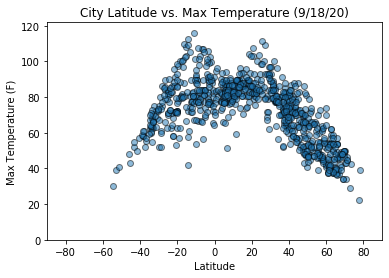

In [5]:
#plot Lat vs Temp
plt.scatter(df["Lat"], df["Max Temp"], marker="o", alpha=.5, edgecolors= "black")

# Incorporate the other graph properties
plt.title("City Latitude vs. Max Temperature (9/18/20)")
plt.ylabel("Max Temperature (F)")
plt.xlabel("Latitude")

plt.xlim(-90, 90)
plt.ylim(0, df['Max Temp'].astype(float).max()*1.05)

# Save the figure
plt.savefig("LatvsMaxTemp091820.png")

# Show plot
plt.show()

## Latitude vs. Humidity Plot

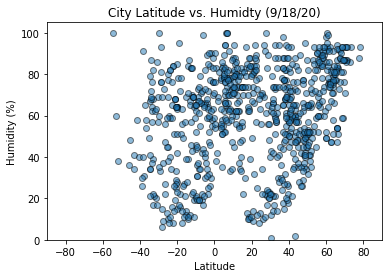

In [6]:
#plot Lat vs Hum
plt.scatter(df["Lat"], df["Humidity"], marker="o", alpha=.5, edgecolors= "black")

# Incorporate the other graph properties
plt.title("City Latitude vs. Humidty (9/18/20)")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")

plt.xlim(-90, 90)
plt.ylim(0, df['Humidity'].astype(float).max()*1.05)

# Save the figure
plt.savefig("LatvsHum091820.png")

# Show plot
plt.show()

## Latitude vs. Cloudiness Plot

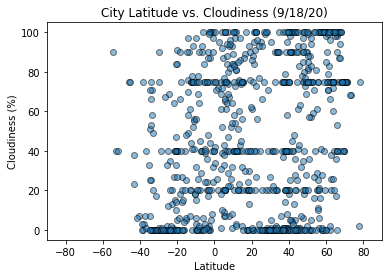

In [7]:
#plot Lat vs Cld
plt.scatter(df["Lat"], df["Cloudiness"], marker="o", alpha=.5, edgecolors= "black")

# Incorporate the other graph properties
plt.title("City Latitude vs. Cloudiness (9/18/20)")
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")

plt.xlim(-90, 90)
plt.ylim(-5, df['Cloudiness'].astype(float).max()*1.05)

# Save the figure
plt.savefig("LatvsCloud091820.png")

# Show plot
plt.show()

## Latitude vs. Wind Speed Plot

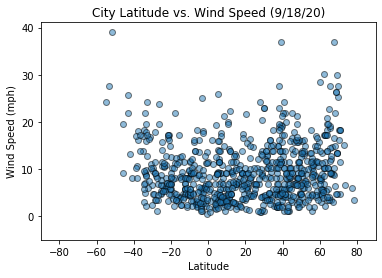

In [8]:
#plot Lat vs Wind Speed
plt.scatter(df["Lat"], df["Wind Speed"], marker="o", alpha=.5, edgecolors= "black")

# Incorporate the other graph properties
plt.title("City Latitude vs. Wind Speed (9/18/20)")
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")

plt.xlim(-90, 90)
plt.ylim(-5, df['Wind Speed'].astype(float).max()*1.05)

# Save the figure
plt.savefig("LatvsWindSpeed091820.png")

# Show plot
plt.show()

## Linear Regression

In [9]:
df_north = df[df["Lat"] >= 0]
df_south = df[df["Lat"] < 0]
df_south

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
1,hithadhoo,-0.60,73.08,82.53,76,24,3.76,MV,1600443347
3,ushuaia,-54.80,-68.30,30.20,100,90,24.16,AR,1600443348
6,caravelas,-17.71,-39.25,81.84,56,14,11.36,BR,1600443349
7,mounana,-1.41,13.16,89.60,55,40,6.93,GA,1600443349
9,bredasdorp,-34.53,20.04,62.60,67,51,18.34,ZA,1600443350
...,...,...,...,...,...,...,...,...,...
781,coihueco,-36.62,-71.83,57.20,54,1,17.22,CL,1600443515
785,aranos,-24.13,19.12,85.30,11,0,5.44,NaN,1600443516
786,resistencia,-27.46,-58.98,84.99,37,0,8.05,AR,1600443516
790,moron,-34.65,-58.62,70.00,34,0,6.93,AR,1600443517


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

y = -0.67x + 94.32
The r-value is: -0.7910476978913553


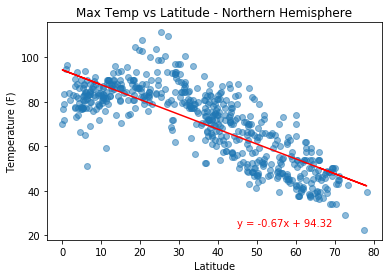

In [18]:
x_values = df_north["Lat"]
y_values = df_north["Max Temp"]

# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
plt.scatter(x_values, y_values, alpha=0.5)
plt.title("Max Temp vs Latitude - Northern Hemisphere")
plt.ylabel("Temperature (F)")
plt.xlabel("Latitude")

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = df_north["Lat"] * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
print(line_eq)

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (45, 24), fontsize=10, color="red")
print(f"The r-value is: {rvalue}")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.5827604488951428


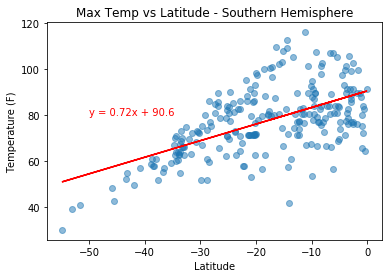

In [26]:
x_values = df_south["Lat"]
y_values = df_south["Max Temp"]

plt.scatter(x_values, y_values, alpha=0.5)
plt.title("Max Temp vs Latitude - Southern Hemisphere")
plt.ylabel("Temperature (F)")
plt.xlabel("Latitude")

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = df_south["Lat"] * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-50, 80), fontsize=10, color="red")
print(f"The r-value is: {rvalue}")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.1199403306605349


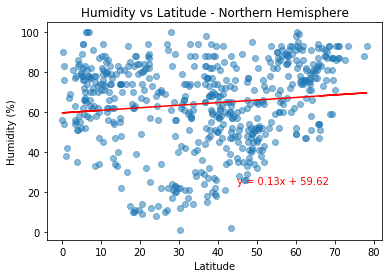

In [20]:
x_values = df_north["Lat"]
y_values = df_north["Humidity"]

plt.scatter(x_values, y_values, alpha=0.5)
plt.title("Humidity vs Latitude - Northern Hemisphere")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = df_north["Lat"] * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (45, 24), fontsize=10, color="red")
print(f"The r-value is: {rvalue}")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.0590450518779099


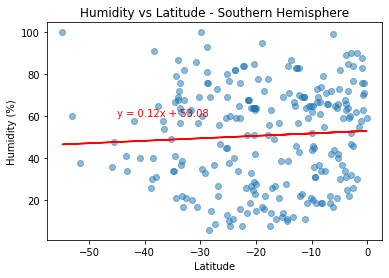

In [27]:
x_values = df_south["Lat"]
y_values = df_south["Humidity"]

plt.scatter(x_values, y_values, alpha=0.5)
plt.title("Humidity vs Latitude - Southern Hemisphere")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-45, 60), fontsize=10, color="red")
print(f"The r-value is: {rvalue}")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.1136371516953329


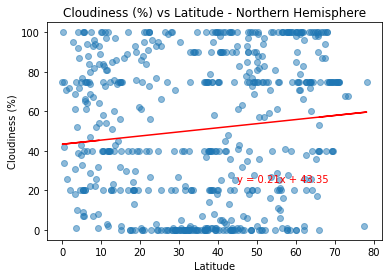

In [22]:
x_values = df_north["Lat"]
y_values = df_north["Cloudiness"]

plt.scatter(x_values, y_values, alpha=0.5)
plt.title("Cloudiness (%) vs Latitude - Northern Hemisphere")
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (45, 24), fontsize=10, color="red")
print(f"The r-value is: {rvalue}")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.24658317751960288


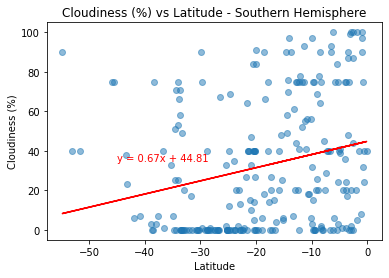

In [30]:
x_values = df_south["Lat"]
y_values = df_south["Cloudiness"]

plt.scatter(x_values, y_values, alpha=0.5)
plt.title("Cloudiness (%) vs Latitude - Southern Hemisphere")
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-45, 35), fontsize=10, color="red")
print(f"The r-value is: {rvalue}")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.24508436882950896


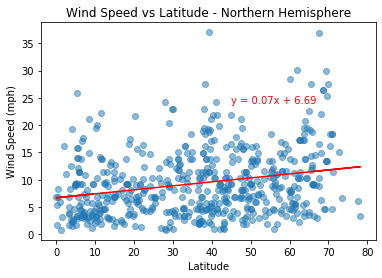

In [31]:
x_values = df_north["Lat"]
y_values = df_north["Wind Speed"]

plt.scatter(x_values, y_values, alpha=0.5)
plt.title("Wind Speed vs Latitude - Northern Hemisphere")
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (45, 24), fontsize=10, color="red")
print(f"The r-value is: {rvalue}")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.43266739060126647


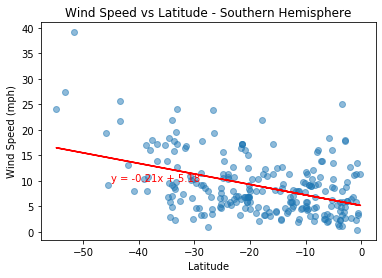

In [33]:
x_values = df_south["Lat"]
y_values = df_south["Wind Speed"]

plt.scatter(x_values, y_values, alpha=0.5)
plt.title("Wind Speed vs Latitude - Southern Hemisphere")
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")

# Run the regression and store each of the returned values
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the predictions for each value of x
regression_values = x_values * slope + intercept

# store a string version of the linear equation, so we can display it on the plot
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot the regression line
plt.plot(x_values, regression_values, "red")

# Annotate the plot with the linear equation
plt.annotate(line_eq, (-45, 10), fontsize=10, color="red")
print(f"The r-value is: {rvalue}")
plt.show()